In [1]:
from stacked_mnist import *
from verification_net import VerificationNet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from autoencoder import Autoencoder
from util import *

In [2]:
# GLOBALS
BATCH_SIZE = 1024
EPOCHS = 15
NUM_CHANNELS = 1


In [3]:
data = StackedMNISTData(mode=DataMode.COLOR_BINARY_COMPLETE)

train_dataset = data.get_full_data_set(training=True)
test_dataset = data.get_full_data_set(training=False)

In [4]:
class StackedMnistDataset(Dataset):
    def __init__(self, data):
        self.X = torch.from_numpy(data[0]).float()
        self.y = torch.from_numpy(data[1]).float()
        # turn them into long tensors
        self.y = self.y.long()
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [5]:
stacked_mnist_train = StackedMnistDataset(train_dataset)
stacked_mnist_test = StackedMnistDataset(test_dataset)

train_loader = DataLoader(stacked_mnist_train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(stacked_mnist_test, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
for x, y in train_loader:
    # reshape to (batch_size, num_channels, height, width)
    #x = x.reshape(-1, 3, 28, 28)
    print(x.shape)
    print(y.shape)
    break

torch.Size([1024, 28, 28, 3])
torch.Size([1024])


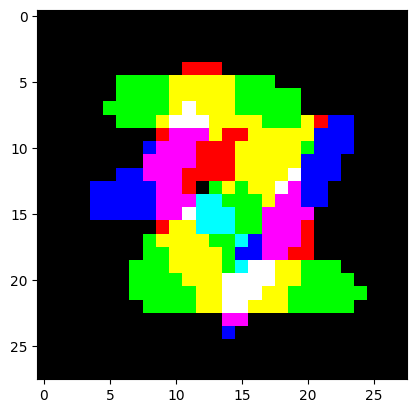

In [7]:
#plt.imshow(next(iter(train_loader))[0][3])
plt.imshow(next(iter(train_loader))[0][0])

In [8]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
model = Autoencoder()
criterion = nn.BCELoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

model.to(device)

device: cuda


Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.2)
    (13): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=16, out_features=32

In [9]:
def train(epochs=EPOCHS, force_retrain=False):

    # try to load the model if it exists and force_retrain is False
    if not force_retrain:
        try:
            checkpoint = torch.load("./models/stacked_gen_autoencoder.pth")
            model.load_state_dict(checkpoint["model_state_dict"])
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            start_epoch = checkpoint["epoch"] + 1
            print("Loaded checkpoint from epoch", start_epoch)
        except:
            start_epoch = 0
            print("Starting from scratch")
    else:
        start_epoch = 0
        print("Starting from scratch (forced retrain)")

    # train the model
    outputs = []
    model.train()
    for epoch in range(start_epoch, epochs):
        for im, _ in train_loader:
            num_channels = im.shape[-1]
            im = im.reshape(-1, num_channels, 28, 28)
            im = im.to(device)
            # ===================forward=====================
            output = model(im)
            output = output.squeeze().reshape(-1, num_channels, 28, 28)
            loss = criterion(output, im)
            # ===================backward====================
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, EPOCHS, loss.item()))
        outputs.append((epoch, im, output))

        # save the model
    if outputs:
        checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(checkpoint, "./models/stacked_gen_autoencoder.pth")

    return outputs

In [10]:
EPOCHS = 30
train_outputs = train(epochs=EPOCHS, force_retrain=False)

Starting from scratch
epoch [1/30], loss:0.1458
epoch [2/30], loss:0.1447
epoch [3/30], loss:0.1430
epoch [4/30], loss:0.1410
epoch [5/30], loss:0.1429
epoch [6/30], loss:0.1416
epoch [7/30], loss:0.1397
epoch [8/30], loss:0.1387
epoch [9/30], loss:0.1391
epoch [10/30], loss:0.1400
epoch [11/30], loss:0.1414
epoch [12/30], loss:0.1389
epoch [13/30], loss:0.1375
epoch [14/30], loss:0.1386
epoch [15/30], loss:0.1369
epoch [16/30], loss:0.1377
epoch [17/30], loss:0.1368
epoch [18/30], loss:0.1373
epoch [19/30], loss:0.1373
epoch [20/30], loss:0.1358
epoch [21/30], loss:0.1364
epoch [22/30], loss:0.1381
epoch [23/30], loss:0.1374
epoch [24/30], loss:0.1392
epoch [25/30], loss:0.1361
epoch [26/30], loss:0.1362
epoch [27/30], loss:0.1366
epoch [28/30], loss:0.1352
epoch [29/30], loss:0.1355
epoch [30/30], loss:0.1347


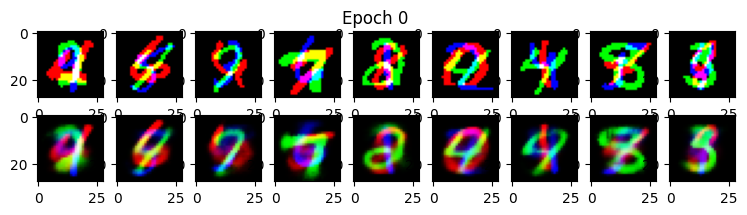

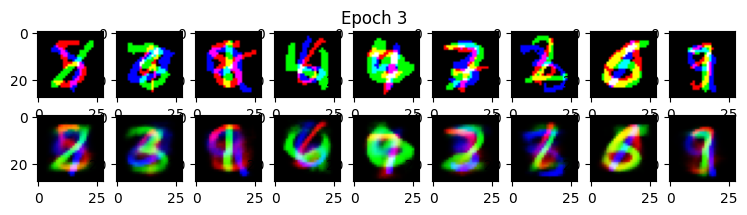

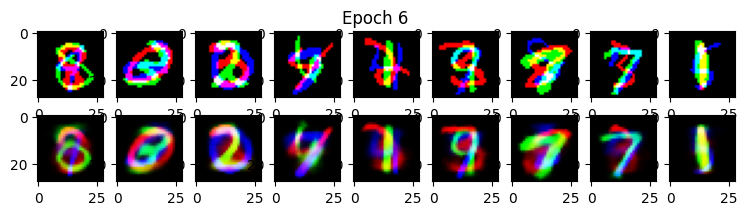

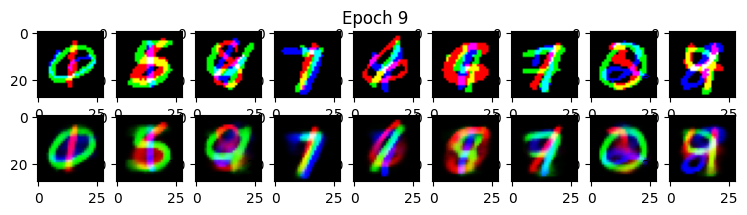

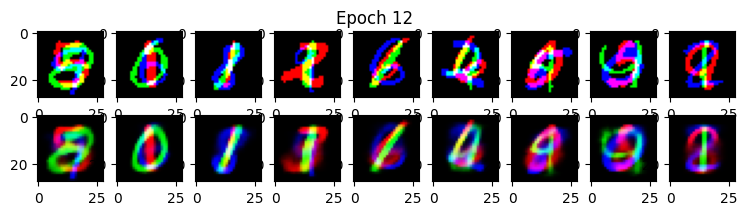

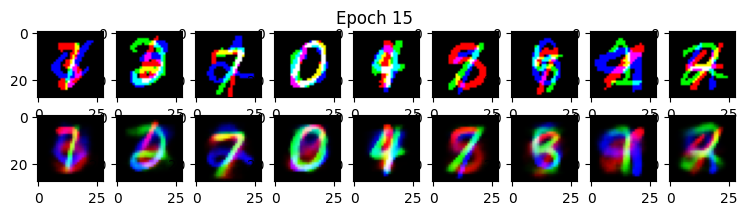

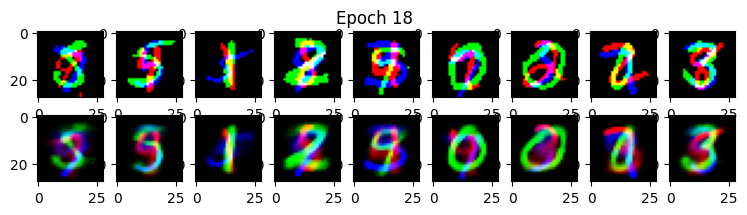

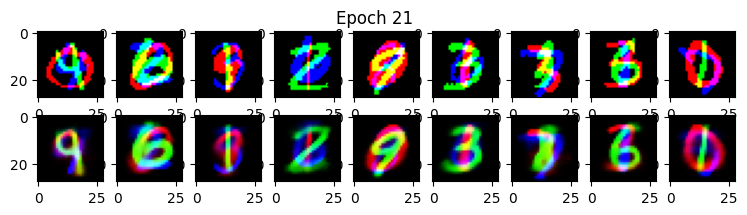

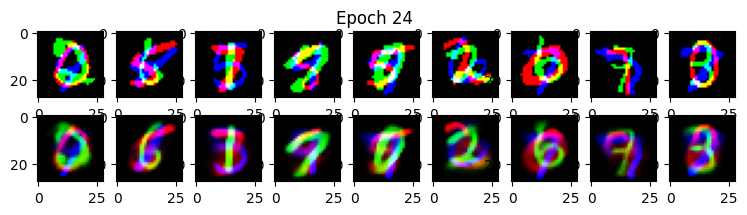

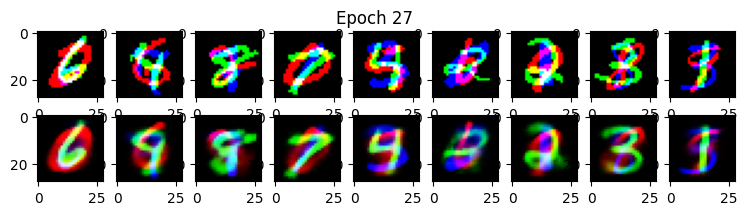

In [11]:
if train_outputs:
    # ensure 10 iterations
    desired_iterations = 10
    num_train_outputs = len(train_outputs)
    step = max(num_train_outputs // desired_iterations, 1)
    
    for k in range(0, EPOCHS, step):
        plt.figure(figsize=(9, 2))
        plt.gray()

        imgs = train_outputs[k][1].reshape(-1, 28, 28, 3).detach().cpu().numpy()
        recon = train_outputs[k][2].reshape(-1, 28, 28, 3).detach().cpu().numpy()

        for i, item in enumerate(imgs):
            if i >= 9:
                break
            plt.subplot(2, 9, i + 1)
            plt.imshow(item)

        for i, item in enumerate(recon):
            if i >= 9:
                break
            plt.subplot(2, 9, 9 + i + 1)
            plt.imshow(item)

        plt.suptitle(f"Epoch {k}")

In [12]:
im, label = next(iter(test_loader))
z = torch.rand(4, 3, 16).to(device) # 4 images, 3 channels, 16 latent features
z.shape

res = model.generate(z).detach().squeeze().cpu().numpy()
res = res.reshape(-1, 28, 28, 3)
res.shape

(4, 28, 28, 3)

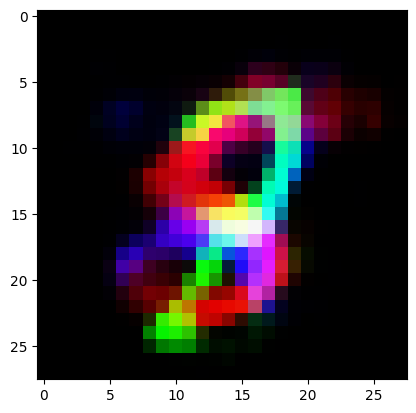

In [13]:
plt.imshow(res[0])

In [14]:
# run the model on the test set
test_outputs, test_labels = generate_test_images(model, test_loader, device)
test_outputs, test_labels = test_outputs.cpu().numpy(), test_labels.cpu().numpy()

(1, 28, 28, 3)
702


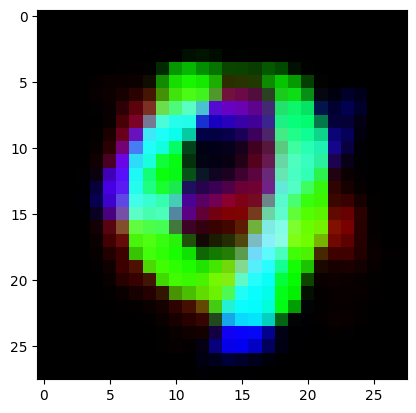

In [15]:
k = 22
test_im = test_outputs[k].reshape(1, 28, 28, 3)
print(test_im.shape)
print(test_labels[k])
plt.imshow(test_outputs[k])


In [19]:
verification_net = VerificationNet()

Could not read weights for verification_net from file. Must retrain...


In [17]:
predictability, accuracy = verification_net.check_predictability(test_outputs, test_labels, tolerance=0.5)
coverage = verification_net.check_class_coverage(test_outputs, tolerance=0.5)
print(f"Predictability: {predictability} \nAccuracy: {accuracy} \nCoverage: {coverage}")

ValueError: Model is not trained, so makes no sense to try to use it

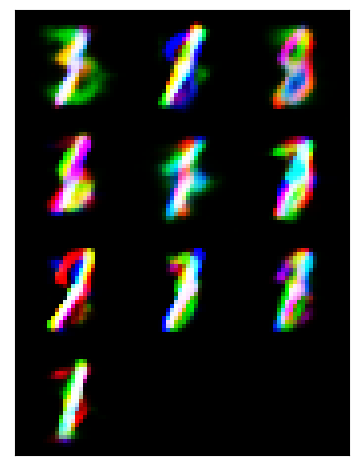

ValueError: Model is not trained, so makes no sense to try to use it

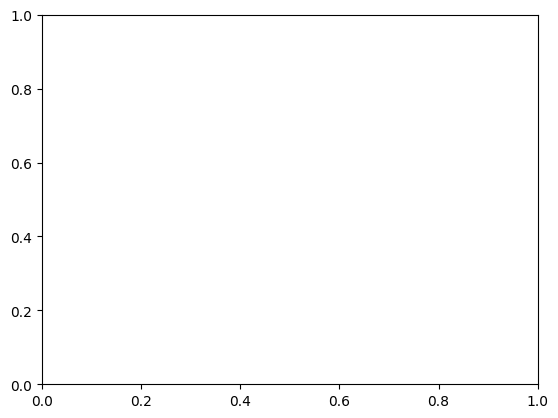

In [21]:
with torch.no_grad():
    num_samples = 10
    z = torch.rand(num_samples, 3, 16).to(device) # <num_samples> images, 3 channels, 16 latent features
    generative_out = model.generate(z).reshape(-1, 28, 28, 3).detach().squeeze().cpu().numpy()
    tiled_image = tile_images(generative_out, show=True)

    generative_predictability, generative_accuracy = verification_net.check_predictability(generative_out, tolerance=0.5)
    # generative_coverage = verification_net.check_class_coverage(generative_out, tolerance=0.5)
    # print(f"Predictability: {generative_predictability} \nAccuracy: {generative_accuracy} \nCoverage: {generative_coverage}")

In [ ]:
im, label = next(iter(test_loader))
z = torch.rand(4, 3, 16).to(device) # 4 images, 3 channels, 16 latent features
z.shape

res = model.generate(z).detach().squeeze().cpu().numpy()
res = res.reshape(-1, 28, 28, 3)
res.shape

Sequential(
  (0): Linear(in_features=16, out_features=32, bias=True)
  (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.2)
  (3): Linear(in_features=32, out_features=64, bias=True)
  (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Unflatten(dim=1, unflattened_size=(64, 1, 1))
  (7): ConvTranspose2d(64, 32, kernel_size=(7, 7), stride=(1, 1))
  (8): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): LeakyReLU(negative_slope=0.2)
  (10): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): LeakyReLU(negative_slope=0.2)
  (13): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (14): Sigmoid()
)